# **FOREST FIRE DETECTION**

In [ ]:
!pip install torch torchvision matplotlib scikit-learn opencv-python --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.5 MB/s eta 0:00:00


# Loading Dataset


In [ ]:
import zipfile
import os


zip_file = 'archive.zip'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('unzipped')


train_dir = 'unzipped/Forest Fire Dataset/Training'

print("🔥 Fire images:", len(os.listdir(os.path.join(train_dir, 'fire'))))
print("🌿 No Fire images:", len(os.listdir(os.path.join(train_dir, 'nofire'))))


🔥 Fire images: 760
🌿 No Fire images: 760


# Importing Necessary Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
data_dir = 'unzipped/Forest Fire Dataset/Training'

# Visualizing Class Distribution

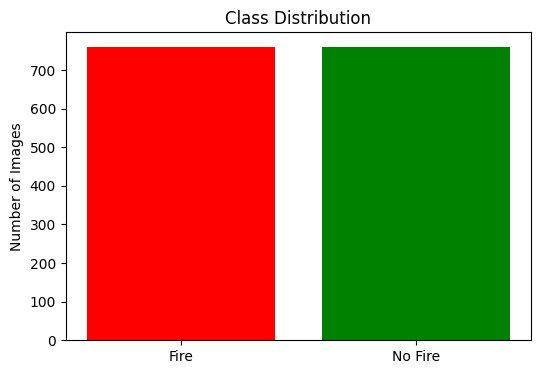

In [ ]:
import matplotlib.pyplot as plt

fire_count = len(os.listdir(os.path.join(train_dir, 'fire')))
nofire_count = len(os.listdir(os.path.join(train_dir, 'nofire')))

plt.figure(figsize=(6, 4))
plt.bar(['Fire', 'No Fire'], [fire_count, nofire_count], color=['red', 'green'])
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.show()


# Image Pre-Processing

In [ ]:
import torchvision.transforms.functional as TF
from PIL import Image

class CustomTransform:
    def __init__(self):
        self.resize = transforms.Resize((224, 224))
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                              [0.229, 0.224, 0.225])

    def __call__(self, img):

        img_cv = np.array(img)
        img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2HSV)
        img_cv = cv2.GaussianBlur(img_cv, (3, 3), 0)
        img_pil = Image.fromarray(cv2.cvtColor(img_cv, cv2.COLOR_HSV2RGB))

        img_resized = self.resize(img_pil)
        img_tensor = self.to_tensor(img_resized)
        return self.normalize(img_tensor)


# Visualizing Pre-Processing

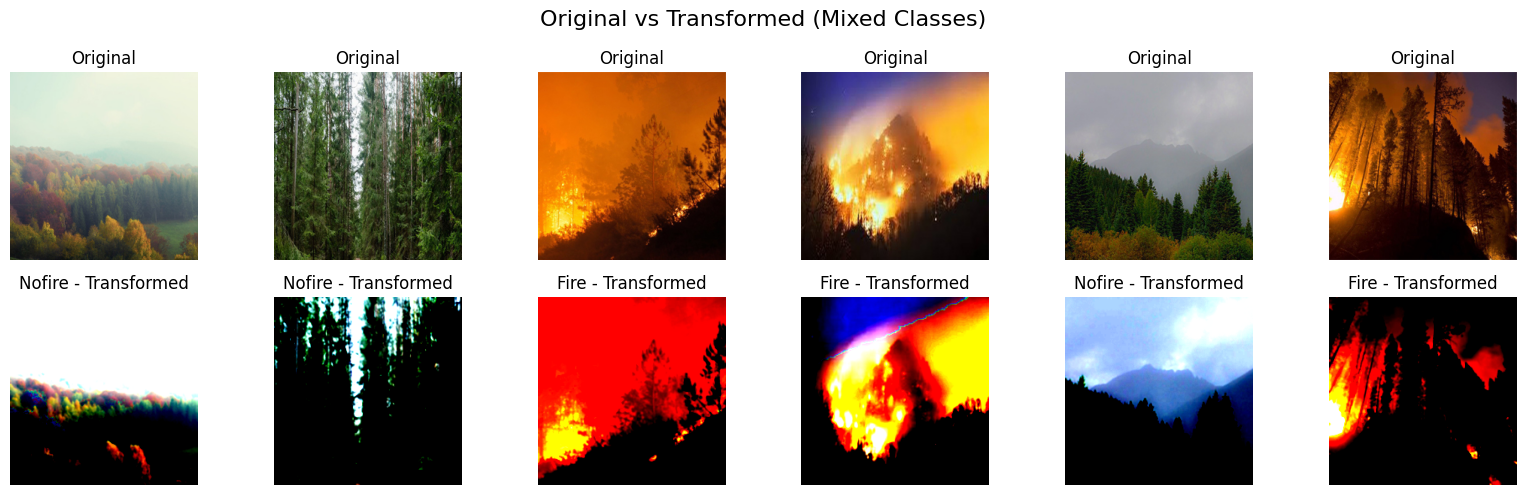

In [ ]:
def visualize_mixed_transformations(dataset_path, transform, num_images=6):
    classes = ['fire', 'nofire']
    samples = []


    for cls in classes:
        class_dir = os.path.join(dataset_path, cls)
        images = random.sample(os.listdir(class_dir), num_images // 2)
        samples.extend([(os.path.join(class_dir, img), cls) for img in images])

    random.shuffle(samples)

    fig, axs = plt.subplots(2, num_images, figsize=(16, 5))

    for i, (img_path, cls) in enumerate(samples):
        img = Image.open(img_path)

        transformed_tensor = transform(img)
        transformed_img = transformed_tensor.permute(1, 2, 0).numpy()
        transformed_img = np.clip(transformed_img, 0, 1)

        # Original
        axs[0][i].imshow(img)
        axs[0][i].axis('off')
        axs[0][i].set_title("Original")

        # Transformed
        axs[1][i].imshow(transformed_img)
        axs[1][i].axis('off')
        axs[1][i].set_title(f"{cls.capitalize()} - Transformed")

    plt.suptitle("Original vs Transformed (Mixed Classes)", fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_mixed_transformations(train_dir, CustomTransform(), num_images=6)


# Transforming and Loading Dataset

In [ ]:
transform = CustomTransform()
dataset = datasets.ImageFolder(data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = dataset.classes


# Setting up the Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


# Training the Model

In [ ]:
train_losses = []
epochs=10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/10], Loss: 0.1309
Epoch [2/10], Loss: 0.0204
Epoch [3/10], Loss: 0.0065
Epoch [4/10], Loss: 0.0035
Epoch [5/10], Loss: 0.0028
Epoch [6/10], Loss: 0.0054
Epoch [7/10], Loss: 0.0037
Epoch [8/10], Loss: 0.0010
Epoch [9/10], Loss: 0.0015
Epoch [10/10], Loss: 0.0007


# Visualizing training loss

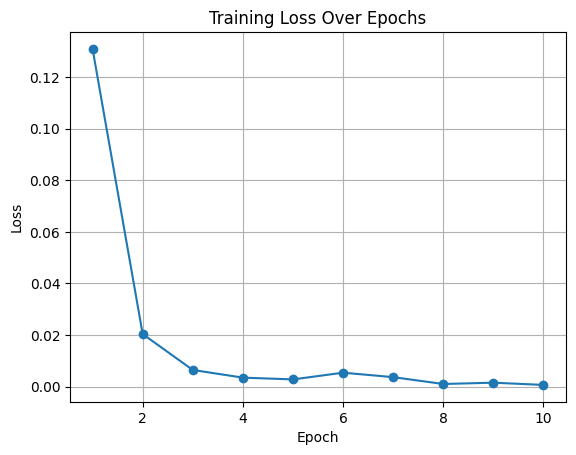

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), train_losses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


# Evaluating the Model

In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(preds.cpu().tolist())
print(classification_report(y_true, y_pred, target_names=class_names))

accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print(f"Accuracy: {accuracy:.4f}")


              precision    recall  f1-score   support

        fire       0.99      0.99      0.99       159
      nofire       0.99      0.99      0.99       145

    accuracy                           0.99       304
   macro avg       0.99      0.99      0.99       304
weighted avg       0.99      0.99      0.99       304

Accuracy: 0.9901


# Confusion Matrix

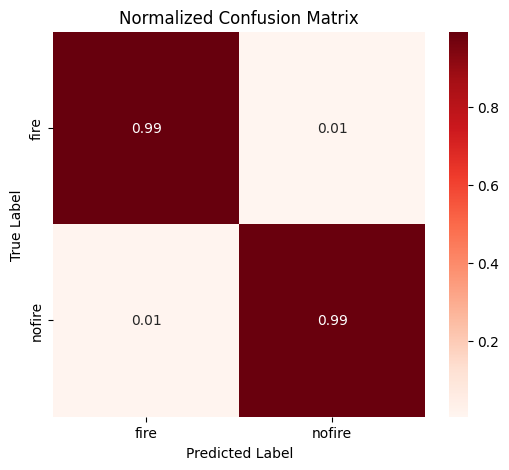

In [ ]:
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Reds",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Normalized Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


# Testing the Model

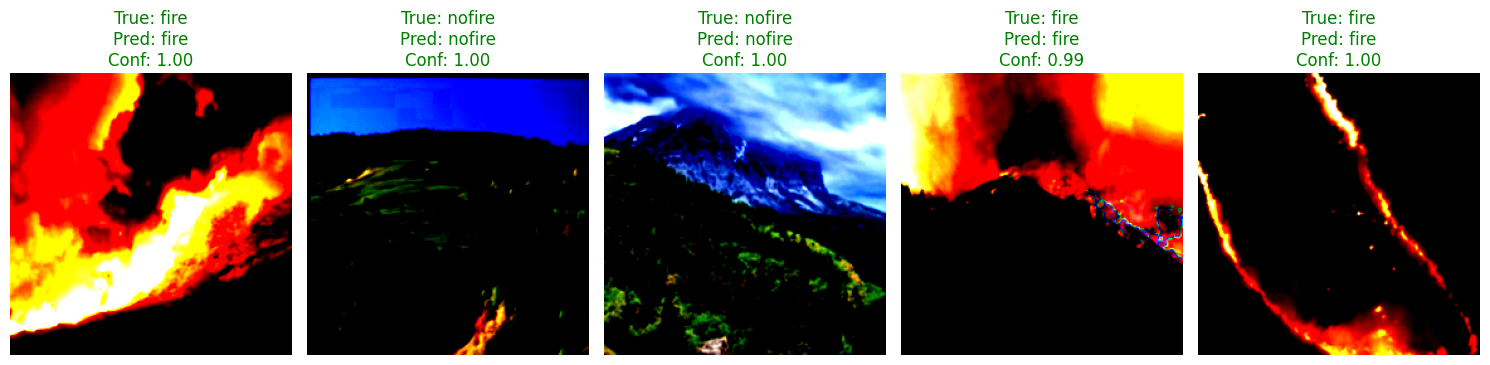

In [ ]:
import torch
import matplotlib.pyplot as plt
import random

def show_predictions(model, dataset, num_images=5):
    model.eval()
    fig, ax = plt.subplots(1, num_images, figsize=(15, 5))

    random_indices = random.sample(range(len(dataset)), num_images)

    for i, idx in enumerate(random_indices):
        img, label = dataset[idx]
        input_tensor = img.unsqueeze(0).to(device)


        with torch.no_grad():
            output = model(input_tensor)
            _, pred = torch.max(output, 1)
            prob = torch.nn.functional.softmax(output, dim=1)
            confidence = prob[0, pred].item()

        ax[i].imshow(img.permute(1, 2, 0).cpu().numpy())


        true_label = class_names[label]
        predicted_label = class_names[pred.item()]


        if true_label == predicted_label:
            ax[i].set_title(f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}", color='green')
        else:
            ax[i].set_title(f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}", color='red')

        ax[i].axis('off')

    plt.tight_layout()
    plt.show()


show_predictions(model, val_dataset, num_images=5)


In [ ]:
# 💾 Save the trained model
torch.save(model.state_dict(), 'forest_fire_detector.pth')
print("✅ Model saved as 'forest_fire_detector.pth'")


✅ Model saved as 'forest_fire_detector.pth'
